# PCA Clustering
1. Use sentence-transformer to embed each sentence
1. Use `scikit learn` for PCA clustering
1. Examine the contents of each cluster 
2. Reference the map back to the sentence to determine an appropriate label for the entire cluster


In [1]:
!pip install texthero -q
!pip install sentence-transformers -q
!pip install hdbscan -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torcheia 1.0.0 requires torch==1.5.1, but you have torch 1.13.1 which is incompatible.


In [2]:
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
import texthero as hero
import os

# Identify the working directory and data files
working_directory = './pca_clustering'

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047086 sha256=ab49aa1e060fdd4cf03ba8ff5c5f697ad5f045e5c0e39c56b4fa7b4f7c48a630
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en_core_web_sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
data_file = './data_stratification/qbj_2020_strata.csv'

# Read the data into a pandas dataframe
df = pd.read_csv(data_file,           # The data file being read, from the variable assignment above
                 on_bad_lines='warn', # This tells Pandas to only warn on bad lines vs causing an error
                 dtype='str')         # This tells Pandas to treat all numbers as words

In [4]:
# The column names were reset here because the CSV import was
# bringing in two unnamed columns for the IDs
df.columns = ['ID1', 'ID2', 'FOI_TEXT', 'DEVICE_PROBLEM_CODE',
       'DEVICE_PROBLEM_TEXT', 'GENERIC_NAME', 'DEVICE_REPORT_PRODUCT_CODE',
       'UDI-DI', 'UDI-PUBLIC', 'DATE_OF_EVENT', 'REPORTER_OCCUPATION_CODE',
       'REPORT_DATE', 'EVENT_LOCATION', 'SOURCE_TYPE']

In [5]:
df.shape

(2763, 14)

In [6]:
df.head(3)

ID1      ID2                                           FOI_TEXT  \
0  1969025  2146218  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1  1426265  1554877  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  2840023  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   

  DEVICE_PROBLEM_CODE             DEVICE_PROBLEM_TEXT  \
0                3283  Wireless Communication Problem   
1                3283  Wireless Communication Problem   
2                1435                No Device Output   

                 GENERIC_NAME DEVICE_REPORT_PRODUCT_CODE          UDI-DI  \
0  CONTINUOUS GLUCOSE MONITOR                        QBJ             NaN   
1  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
2  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   

       UDI-PUBLIC DATE_OF_EVENT REPORTER_OCCUPATION_CODE REPORT_DATE  \
0             NaN    07/30/2020                      000         NaN   
1  00386270000385    06/05/2020                      000         NaN   
2  00386270000385    10/05/2020                      000         NaN   

  EVENT_LOCATION SOURCE_TYPE  
0              I    CONSUMER  
1              I    CONSUMER  
2              I    CONSUMER

## Sentence-ize the FOI_TEXT Data 
Before the `FOI_TEXT` can be processed, it needs to be broken up into sentences.

For further analysis, each sentence needs to be associated with the `FOI_TEXT` row that it came from.

[This discussion from Stack Overflow](https://stackoverflow.com/a/43922444/2308522) provides a suggestion for breaking the code into a dataframe of sentences with each sentence retaining the ID of the row where it was originally located.

[This page from the Pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.itertuples.html) provides details on using the `itertuples()` function to process the rows of the dataframe.

In [7]:
sentences = []

# Using itertuples(), the columns must be addressed using thier position.
# Here's a map of position to name:
# row[1]: ID1
# row[3]: FOI_TEXT
# row[5]: DEVICE_PROBLEM_TEXT
for row in df.itertuples():
    for sentence in row[3].split('.'):
        if sentence != '':
            sentences.append([row[1],row[5],sentence])

sentences_df = pd.DataFrame(sentences, columns=['ID1','DEVICE_PROBLEM_TEXT','SENTENCE'])

In [8]:
sentences_df.shape

(12399, 3)

In [9]:
sentences_df.head(3)

ID1             DEVICE_PROBLEM_TEXT  \
0  1969025  Wireless Communication Problem   
1  1969025  Wireless Communication Problem   
2  1969025  Wireless Communication Problem   

                                            SENTENCE  
0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...  
1   THE TRANSMITTER ULTIMATELY REGAINED CONNECTIO...  
2   NO ADDITIONAL PATIENT OR EVENT INFORMATION WA...

## Run the PCA Pipeline
Now that each `FOI_TEXT` has been sentencized, the PCA pipeline can be run.

In [10]:
from sentence_transformers import SentenceTransformer

# define the document embedding model
# https://www.sbert.net/docs/pretrained_models.html
embedder = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [11]:
sentences_df['EMBED'] = sentences_df['SENTENCE'].apply(embedder.encode)
sentences_df.head(3)

ID1             DEVICE_PROBLEM_TEXT  \
0  1969025  Wireless Communication Problem   
1  1969025  Wireless Communication Problem   
2  1969025  Wireless Communication Problem   

                                            SENTENCE  \
0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1   THE TRANSMITTER ULTIMATELY REGAINED CONNECTIO...   
2   NO ADDITIONAL PATIENT OR EVENT INFORMATION WA...   

                                               EMBED  
0  [0.0034748917, 0.043741446, -0.005506493, 0.05...  
1  [-0.041658804, 0.052052416, 0.0008737245, 0.04...  
2  [0.025140468, 0.054037955, -0.032763645, 0.007...

In [12]:
len(sentences_df.loc[0]['EMBED'])

384

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# "np.array([i for i in sentences_df['EMBED']])" Converts the data into a 2d array
embed_scaled = scaler.fit_transform(np.array([i for i in sentences_df['EMBED']]))

In [14]:
embed_scaled

array([[0.6104516 , 0.5603009 , 0.41348875, ..., 0.5896765 , 0.4527775 ,
        0.4872991 ],
       [0.4177134 , 0.59542996, 0.43630058, ..., 0.68378276, 0.59077674,
        0.4119441 ],
       [0.70297194, 0.60382247, 0.3160335 , ..., 0.5154353 , 0.4212417 ,
        0.40828767],
       ...,
       [0.8482734 , 0.828407  , 0.46111125, ..., 0.25619125, 0.62865317,
        0.59439254],
       [0.5041959 , 0.37738454, 0.58416235, ..., 0.57327324, 0.5786286 ,
        0.61850226],
       [0.34374842, 0.63194394, 0.38453323, ..., 0.6826074 , 0.66730905,
        0.551384  ]], dtype=float32)

In [15]:
len(embed_scaled)

12399

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

# run it with 2 components
pca = PCA(n_components=3)

# fit it to our data
pca_result = pca.fit_transform(embed_scaled)

# extract the explained variance
explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

# create a t-SNE object and fit and transform the PCA result
tsne = TSNE(n_components=3, init='pca', learning_rate='auto')

tsne_result = tsne.fit_transform(pca_result)

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [29]:
len(pca_result)

12399

In [30]:
pca_result

array([[-0.9986629 , -0.8240318 , -0.79773444],
       [-0.95595753, -0.6479146 , -0.43274015],
       [ 1.2157567 , -0.1980247 , -0.04012394],
       ...,
       [ 2.6174538 , -0.428429  , -0.92314816],
       [-0.5586461 , -0.6374435 ,  0.5305084 ],
       [-0.24635124, -1.0546007 ,  0.80088454]], dtype=float32)

In [31]:
len(tsne_result)

12399

In [32]:
tsne_result

array([[ 12.236797  , -14.851363  , -19.67336   ],
       [-14.783392  ,  -9.389258  ,  -7.6369047 ],
       [ 11.445117  ,  12.722459  ,  -0.09147386],
       ...,
       [ 15.259773  ,  -4.939643  ,  -7.547542  ],
       [ -6.1028175 , -10.189528  ,  18.977232  ],
       [ -6.8444715 , -24.439526  ,  19.84829   ]], dtype=float32)

In [33]:
explained_variance

array([0.16515666, 0.12807289, 0.09767034], dtype=float32)

In [35]:
singular_values

array([140.74377 , 123.93951 , 108.233696], dtype=float32)

In [36]:
from hdbscan import HDBSCAN
hdbscan = HDBSCAN()
clusters = hdbscan.fit_predict(tsne_result)

In [37]:
clusters

array([ -1, 157,  -1, ...,  61,  -1,   4])

In [49]:
len(clusters)

12399

In [ ]:
# Create a grouping of values by cluster value
# ie, clusters[0] and clusters[2] will have the same cluster value.
# sort by size (number of items in the group)
# determine how dense each cluster is 
# use the python 'counter' class

# after sorting, analyze and manually create the cluster 'affinity'
# create a new 'clusters' array with the value for the cluster affinity

# FUTURE: For example,
# classify senteneces into "3" classes
# then have "2" labels
# then combine the labels for the FOI_TEXT
# - use one label for the FOI_TEXT
# - another model or rule that takes the labels and FOI_TEXT as input and determines a single FOI_TEXT label
# - other aggregration strategies for the FOI_TEXT label...


# Reviewing the text
# - all the sentences in the cluster make sense and the entire cluster can be labeled the same
# - or the clustering was bad and has too many exceptions; data needs to be split into a much better clustering
#
# ie, they will be consistent and easily label-able or inconsistent and the clustering method needs to be revisited
# - switch out HDBSCAN
# - reduce dimensionality
# - others...


## Generate a Scatterplot
Using the PCA data, generate a 2D scatterplot.

- [Plotly Color Scales](https://plotly.com/python/builtin-colorscales/)

In [39]:
# break the PCA coordinates into X and Y columns
sentences_df[['x','y','z']] = tsne_result.tolist()

# Merge the PCA data with the main data frame
combined = pd.merge(
        df, 
        sentences_df, 
        on='ID1', 
        how='inner')

combined.to_csv(f"{working_directory}/pca_cluster_notebook_13.csv", index=False)


## Write the Plot to a File

In [61]:
# Using the plotly express library to write the graph
# https://plotly.com/python/interactive-html-export/
import plotly.express as px

# https://plotly.com/python/figure-labels/
fig = px.scatter(
    combined, 
    x='x', 
    y='y',
    color=clusters,
    custom_data=['ID1', 'SENTENCE'],
    title="PCA Scatter Plot in 2D"
)

# https://stackoverflow.com/questions/59057881/python-plotly-how-to-customize-hover-template-on-with-what-information-to-show
fig.update_traces(
    hovertemplate="<br>".join([
        "x: %{x}",
        "y: %{y}",
        "ID1: %{customdata[0]}",
        "S: %{customdata[1]}"
    ])
)

# write the 2d scatter plot to a file in the working directory
fig.write_html(f"{working_directory}/pca_cluster_notebook_13_2d.html")

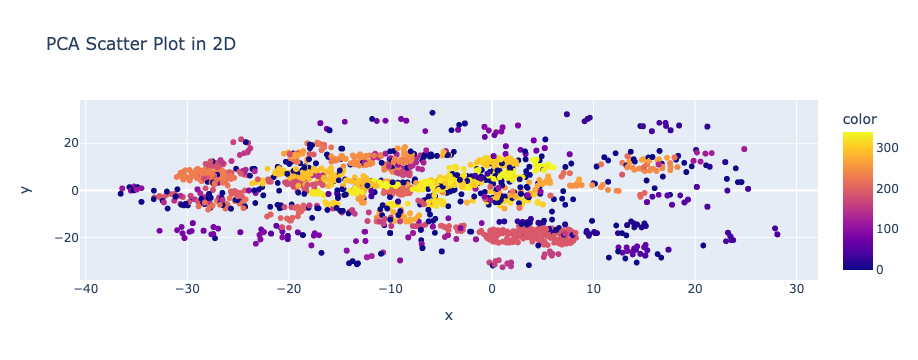

In [62]:
fig.show()

In [ ]:
## Generate a 3D Scatter Plot
Using the PCA data, generate a 3D scatterplot.

In [59]:
import plotly.graph_objs as go

z = np.linspace(0, 10, 50)
x = np.cos(z)
y = np.sin(z)

trace = go.Scatter3d(
    x = sentences_df['x'], 
    y = sentences_df['y'], 
    z = sentences_df['z'], 
    mode = 'markers', 
    marker = dict(
      color=clusters,
      colorscale = 'Plasma'
    )
)

layout = go.Layout(title = "PCA Scatter Plot in 3D")
fig_3d = go.Figure(data = [trace], layout = layout)

# write the 3d scatter plot to a file in the working directory
fig_3d.write_html(f"{working_directory}/pca_cluster_notebook_13_3d.html")

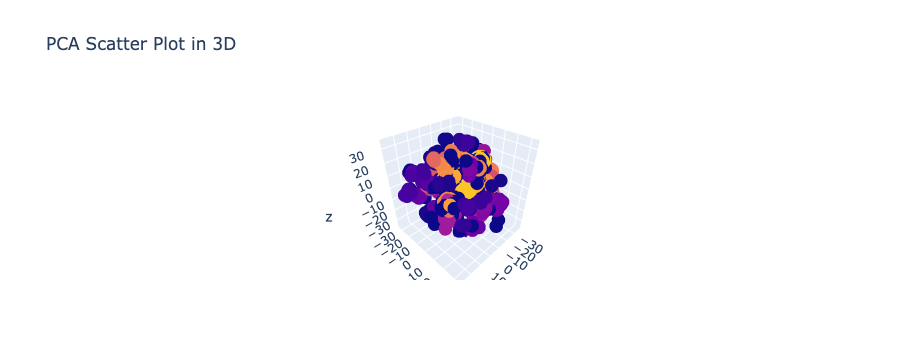

In [60]:
fig_3d.show()

# Next steps
- Need to identify and segregate clusters so FOI text can be manually reviewed.
